In [38]:
import utils.constants as const
import utils.pathbuilder as upb
import os
import string
import random
import csv
from PIL import Image
import numpy as np
import skimage.io
from skimage.color import rgba2rgb, rgb2gray, gray2rgb
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

In [40]:
FOLDER_NAME = './train-img/'
TRAIN_FOLDER = './train/'
VALIDATION_FOLDER = './validation/'
TEST_FOLDER = './test/'
PREVIEW_FOLDER = './preview/'
REDUCED_FOLDER = './reduced/'
IGNORED_FILES = ['.DS_Store']
TRAIN_DATA = './train_data.csv'

In [33]:
# Create a folder un current directory if not exists
def create_folder_if_not_exists(folder_name):
    if os.path.isdir(folder_name) == False:
        os.makedirs(folder_name)

In [36]:
def id_generator(size=10, chars=string.ascii_uppercase + string.digits):
    return ''.join(random.choice(chars) for _ in range(size))

In [37]:
id_generator()

'MCKVFOYRS8'

In [22]:
create_folder_if_not_exists(TRAIN_FOLDER)
create_folder_if_not_exists(VALIDATION_FOLDER)
create_folder_if_not_exists(TEST_FOLDER)
create_folder_if_not_exists(PREVIEW_FOLDER)
create_folder_if_not_exists(REDUCED_FOLDER)

In [7]:
print('FINISH CREATION OF FOLDERS')

FINISH CREATION OF FOLDERS


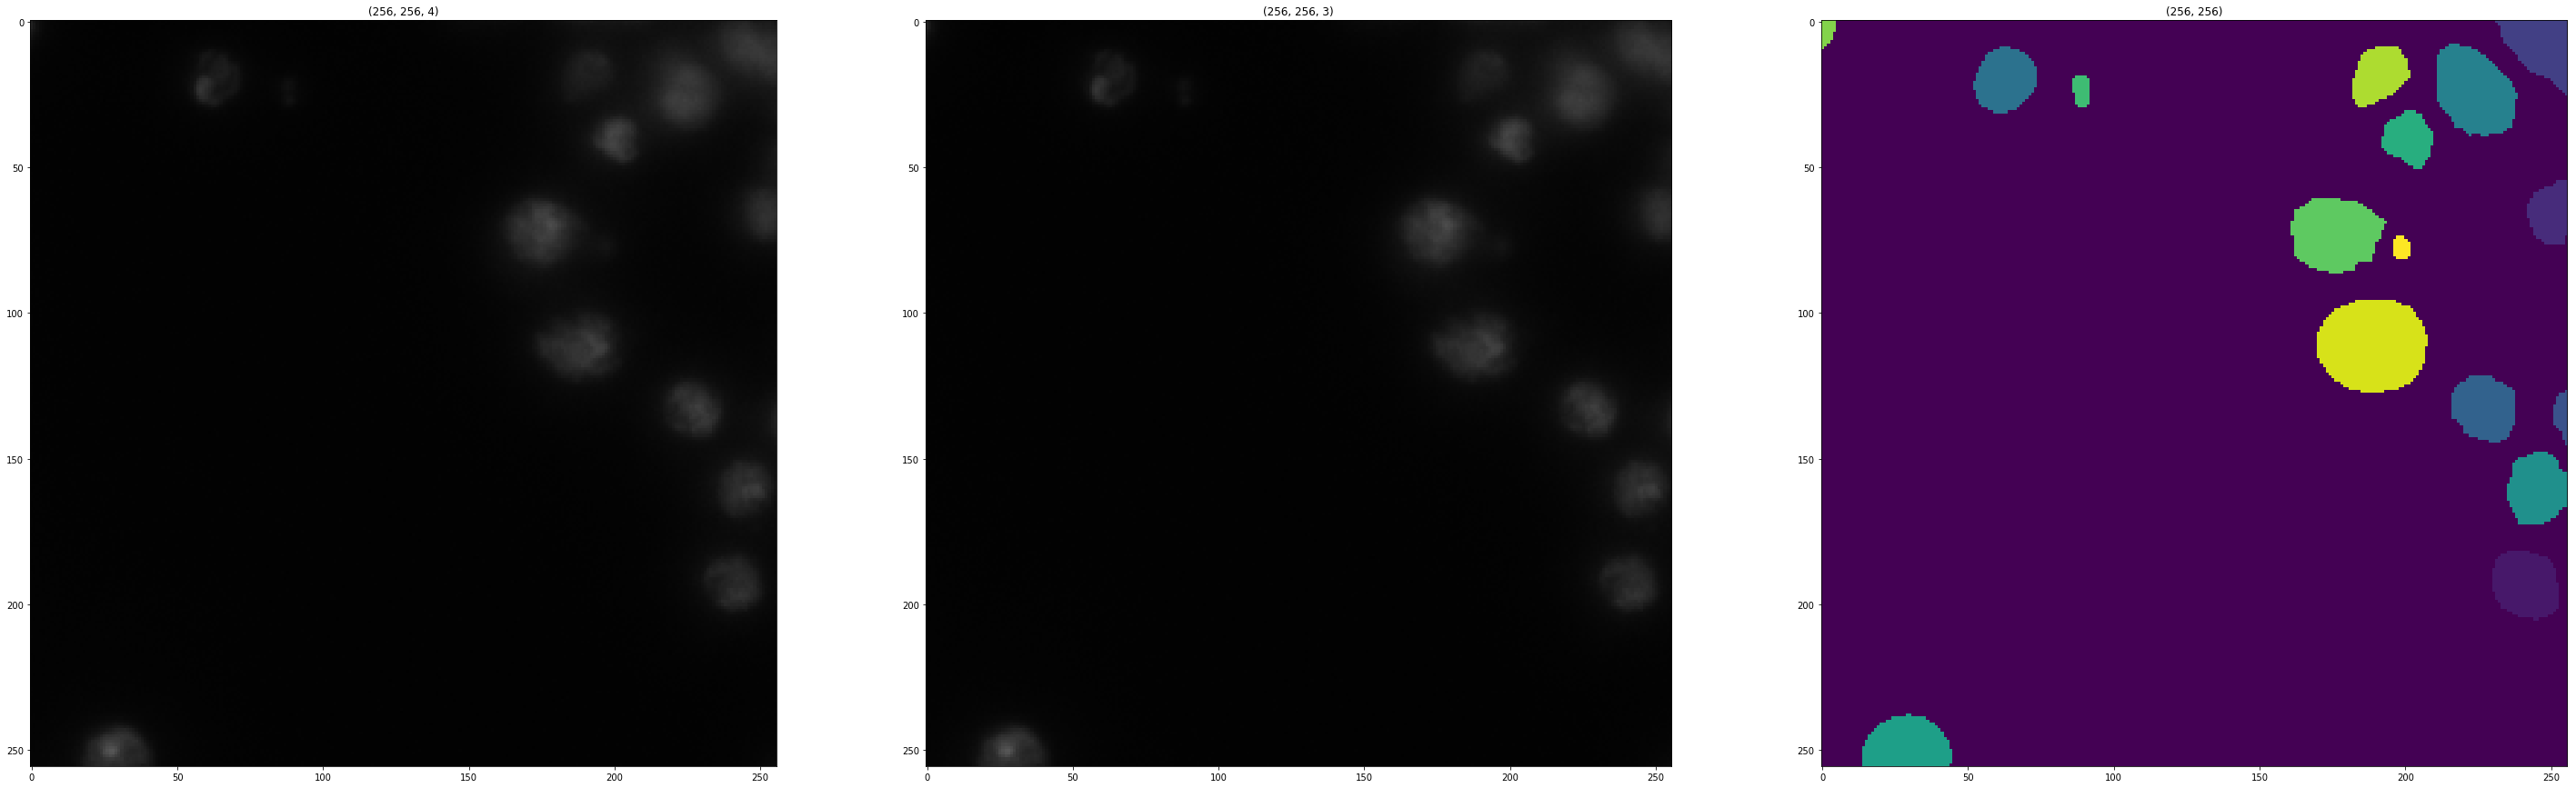

In [43]:
images_id = [x for x in os.listdir(const.STAGE1_TRAIN_PATH)]
plt.close('all')
fig, ax = plt.subplots(nrows=1,ncols=3, figsize=(50,50))
for image_id in images_id:
    if image_id in IGNORED_FILES:
        continue
    image_path = os.path.join(const.STAGE1_TRAIN_PATH, image_id, 'images', '{}.png'.format(image_id))
    mask_paths = os.path.join(const.STAGE1_TRAIN_PATH, image_id, 'masks', '*.png')

    image = skimage.io.imread(image_path)
    masks = skimage.io.imread_collection(mask_paths).concatenate()
    mask = np.zeros(image.shape[:2], np.uint16)
    
    for mask_idx in range(masks.shape[0]):
        mask[masks[mask_idx] > 0] = mask_idx + 1
    
    ax[0].imshow(image)
    ax[0].set_title(image.shape)
    ax[1].imshow(rgba2rgb(image))
    ax[1].set_title(rgba2rgb(image).shape)
    ax[2].imshow(mask)
    ax[2].set_title(mask.shape)
    break

In [62]:
images_id = [x for x in os.listdir(const.STAGE1_TRAIN_PATH)]

for image_id in images_id:
    if image_id in IGNORED_FILES:
        continue
    image_path = os.path.join(const.STAGE1_TRAIN_PATH, image_id, 'images', '{}.png'.format(image_id))
    mask_paths = os.path.join(const.STAGE1_TRAIN_PATH, image_id, 'masks', '*.png')

    image = gray2rgb(rgb2gray(skimage.io.imread(image_path)))
    masks = skimage.io.imread_collection(mask_paths).concatenate()
    mask = np.zeros(image.shape[:2], np.uint16)
    
    for mask_idx in range(masks.shape[0]):
        mask[masks[mask_idx] > 0] = mask_idx + 1
 
    image = np.uint8(image * 255)
    if image.mean() > 255 / 2:
        image = 255 - image
        
    _image = Image.fromarray(image)
    _image.save(os.path.join(PREVIEW_FOLDER,'{}.png'.format(image_id)))
                    
    _mask = Image.fromarray(np.uint8(mask * 255))
    _mask.save(os.path.join(PREVIEW_FOLDER,'{}_mask.png'.format(image_id)))

print("FINISHED")

FINISHED


In [ ]:
train_data = open(TRAIN_DATA, 'w')
csvwriter = csv.writer(train_data)
dict_train = []
padding = 95
print_header = True

for image_id in images_id:
    if image_id in IGNORED_FILES:
        continue
        
    image_path = os.path.join(PREVIEW_FOLDER, '{}.png'.format(image_id))
    mask_path = os.path.join(PREVIEW_FOLDER, '{}_mask.png'.format(image_id))
    
    image = skimage.io.imread(image_path) / 255.
    mask = skimage.io.imread(mask_path) / 255.

    image = np.uint8(image * 255)
    mask = np.uint8(mask * 255)

    w, h, _ = image.shape
    for i in range(w - padding):
        for j in range(h - padding):
            
            sample = image[i: i + padding,j: j + padding, :]
            img = Image.fromarray(sample)
            
            filename = id_generator()
            img.save(os.path.join(REDUCED_FOLDER, filename + '.png'))
            
            isNuclei = mask[int(i + padding / 2)][int(j + padding / 2)]
            data = {
                'id': filename,
                'nuclei': isNuclei
            }
            
            if print_header:
                csvwriter.writerow(data.keys())
                print_header = False
            csvwriter.writerow(data.values())

train_data.close()
print("FINISHED")

In [ ]:
def __main__():
    print("Starting process")
    create_folder_if_not_exists(TRAIN_FOLDER)
    create_folder_if_not_exists(VALIDATION_FOLDER)
    create_folder_if_not_exists(TEST_FOLDER)
    print("TRAIN/VALIDATION/TEST folders created correctly")
    
    